### AlexNet

The network consists of 5 Convolutional (CONV) layers and 3 Fully Connected (FC) layers. The activation used is the Rectified Linear Unit (ReLU).

The network has a total of 62 million trainable variables

The input to the network is a batch of RGB images of size 227x227x3 and outputs a 1000x1 probability vector one corresponding to each class.

![image](network.png)

**Data augmentation (Crop & Mirror):** Data augmentation is carried out to reduce over-fitting. This Data augmentation includes mirroring and cropping the images to increase the variation in the training data-set. The network uses an overlapped max-pooling layer after the first, second, and fifth CONV layers. Overlapped maxpool layers are simply maxpool layers with strides less than the window size. 3x3 maxpool layer is used with a stride of 2 hence creating overlapped receptive fields. This overlapping improved the top-1 and top-5 errors by 0.4% and 0.3%, respectively.  

**Activation Functions (ReLU):** Before AlexNet, the most commonly used activation functions were sigmoid and tanh. Due to the saturated nature of these functions, they suffer from the Vanishing Gradient (VG) problem and make it difficult for the network to train. AlexNet uses the ReLU activation function which doesn’t suffer from the VG problem. The original paper showed that the network with ReLU achieved a 25% error rate about 6 times faster than the same network with tanh non-linearity.  

**Local Response Normalization:** Although ReLU helps with the vanishing gradient problem, due to its unbounded nature, the learned variables can become unnecessarily high. To prevent this, AlexNet introduced Local Response Normalization (LRN). The idea behind LRN is to carry out a normalization in a neighborhood of pixels amplifying the excited neuron while dampening the surrounding neurons at the same time.

**Dropout:** AlexNet also addresses the over-fitting problem by using drop-out layers where a connection is dropped during training with a probability of p=0.5. Although this avoids the network from over-fitting by helping it escape from bad local minima, the number of iterations required for convergence is doubled too.

In [13]:
import torch
import random
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader,random_split
from torchvision import transforms

def get_dataloaders(datasetname, batch_size, validation_fraction=0.2, train_transforms=transforms.ToTensor(), test_transforms=transforms.ToTensor()):
    # Load train and test datasets
    if datasetname == 'CIFAR10':
        train_dataset = datasets.CIFAR10(root='data', train=True, transform=train_transforms, download=True)
        test_dataset = datasets.CIFAR10(root='data', train=False, transform=test_transforms)
    else: # MNIST
        train_dataset = datasets.MNIST(root='data', train=True, transform=train_transforms, download=True)
        test_dataset = datasets.MNIST(root='data', train=False, transform=test_transforms)

    # Split train dataset into train and validation subsets
    train_size = int((1 - validation_fraction) * len(train_dataset))
    valid_size = len(train_dataset) - train_size
    train_subset, val_subset = random_split(train_dataset, [train_size, valid_size])

    # Create data loaders for each subset
    train_loader = DataLoader(train_subset, batch_size, shuffle=True)
    valid_loader = DataLoader(val_subset, batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=True)

    return train_loader, valid_loader, test_loader

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 

def compute_accuracy(model, data_loader, device):
    with torch.no_grad():    
        correct_pred, num_examples = 0, 0
        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()

        return correct_pred.float()/num_examples * 100

In [15]:
### SETTINGS
BATCH_SIZE = 256
NUM_EPOCHS = 50
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
set_seed(123)


### CIFAR10 DATASET
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.RandomCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.RandomCrop((64, 64)),
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader, valid_loader, test_loader = get_dataloaders('CIFAR10', batch_size=BATCH_SIZE, validation_fraction=0.1, train_transforms=train_transforms, test_transforms=test_transforms)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Files already downloaded and verified
Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([2, 7, 4, 7, 0, 1, 1, 6, 9, 2])


##### The AlexNet Network
![image](parameters.png)

```
class AlexNet(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = torch.nn.Sequential(                                    #           [n, 3, 227, 227]
            torch.nn.Conv2d(3, 96,      stride=4, padding=0, kernel_size=11),   #conv1      [n, 96, 55, 55]
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(         stride=2, padding=0, kernel_size=3),    #maxpool1   [n, 96, 27, 27]
            torch.nn.Conv2d(96, 256,    stride=1, padding=2, kernel_size=5),    #conv2      [n, 256, 27, 27]
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(         stride=2, padding=0, kernel_size=3),    #maxpool2   [n, 256, 13, 13]
            torch.nn.Conv2d(256, 384,   stride=1, padding=1, kernel_size=3),    #conv3      [n, 384, 13, 13]
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(384, 384,   stride=1, padding=1, kernel_size=3),    #conv4      [n, 384, 13, 13]
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(384, 256,   stride=1, padding=1, kernel_size=3),    #conv5      [n, 256, 13, 13]
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(         stride=2, padding=0, kernel_size=3),    #maxpool5   [n, 256, 6, 6]
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256 * 6 * 6, 4096),                                 #fc6        9216 = 256 * 6 * 6
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),                                        #fc7
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, num_classes)                                  #fc8
        )        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        return logits
```

In [10]:
import torch.nn.functional as F
import torch.nn as nn

class AlexNet(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.features = torch.nn.Sequential(                                    #           [n, 3, 64, 64]
            torch.nn.Conv2d(3, 64,      stride=4, padding=2, kernel_size=11),   #conv1      [n, 64, 15, 15]
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(         stride=2, padding=0, kernel_size=3),    #maxpool1   [n, 64, 7, 7]
            torch.nn.Conv2d(64, 192,    stride=1, padding=2, kernel_size=5),    #conv2      [n, 192, 7, 7]
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(         stride=2, padding=0, kernel_size=3),    #maxpool2   [n, 192, 3, 3]
            torch.nn.Conv2d(192, 384,   stride=1, padding=1, kernel_size=3),    #conv3      [n, 384, 3, 3]
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(384, 256,   stride=1, padding=1, kernel_size=3),    #conv4      [n, 384, 3, 3]
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(256, 256,   stride=1, padding=1, kernel_size=3),    #conv5      [n, 256, 3, 3]
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(         stride=2, padding=0, kernel_size=3),    #maxpool5   [n, 256, 1, 1]
        )
        self.avgpool = torch.nn.AdaptiveAvgPool2d((6, 6))                       #avgpool    [n, 256, 6, 6]
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256 * 6 * 6, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        return logits

In [19]:
#check if cuda available
print(torch.__version__)
print(torch.version.cuda)

import time
model = AlexNet(num_classes=10)

model = model.to(DEVICE)

#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, mode='max', verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []
start_time = time.time()

for epoch in range(NUM_EPOCHS):

    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        # ## FORWARD AND BACK PROP
        logits = model(features)
        loss = torch.nn.functional.cross_entropy(logits, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ## LOGGING
        minibatch_loss_list.append(loss.item())
        if not batch_idx % 100:
            print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Batch {batch_idx:04d}/{len(train_loader):04d} | Loss: {loss:.4f}')

    model.eval()
    train_acc = compute_accuracy(model, train_loader, device=DEVICE)
    valid_acc = compute_accuracy(model, valid_loader, device=DEVICE)
    print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | Train: {train_acc :.2f}% | Validation: {valid_acc :.2f}%')
    train_acc_list.append(train_acc.item())
    valid_acc_list.append(valid_acc.item())
    
    scheduler.step(valid_acc_list[-1])

elapsed = (time.time() - start_time)/60
print(f'Time elapsed: {elapsed:.2f} min')

test_acc = compute_accuracy(model, test_loader, device=DEVICE)
print(f'Test accuracy {test_acc :.2f}%')

1.13.1
11.7
Epoch: 001/050 Batch 0000/0176 | Loss: 2.3032
Epoch: 001/050 Batch 0100/0176 | Loss: 2.3032
Epoch: 001/050 | Train: 12.64% | Validation: 11.94%
Epoch: 002/050 Batch 0000/0176 | Loss: 2.1862
Epoch: 002/050 Batch 0100/0176 | Loss: 2.2788
Epoch: 002/050 | Train: 16.42% | Validation: 15.96%
Epoch: 003/050 Batch 0000/0176 | Loss: 2.2062
Epoch: 003/050 Batch 0100/0176 | Loss: 2.3028
Epoch: 003/050 | Train: 10.04% | Validation: 9.60%
Epoch: 004/050 Batch 0000/0176 | Loss: 2.3020
Epoch: 004/050 Batch 0100/0176 | Loss: 2.3051
Epoch: 004/050 | Train: 10.01% | Validation: 9.92%
Epoch: 005/050 Batch 0000/0176 | Loss: 2.3023
Epoch: 005/050 Batch 0100/0176 | Loss: 2.2731
Epoch: 005/050 | Train: 17.48% | Validation: 17.44%
Epoch: 006/050 Batch 0000/0176 | Loss: 2.0341
Epoch: 006/050 Batch 0100/0176 | Loss: 1.9259
Epoch: 006/050 | Train: 23.67% | Validation: 24.08%
Epoch: 007/050 Batch 0000/0176 | Loss: 1.8320
Epoch: 007/050 Batch 0100/0176 | Loss: 1.7570
Epoch: 007/050 | Train: 36.50% | V

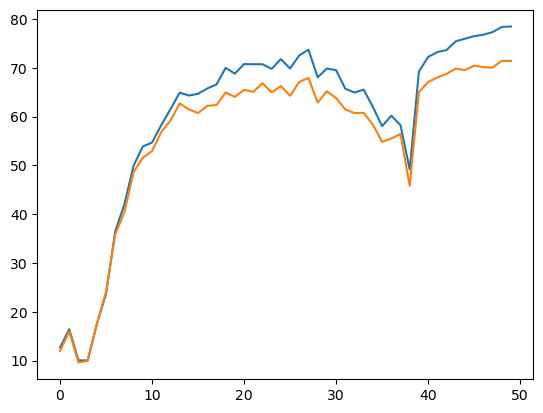

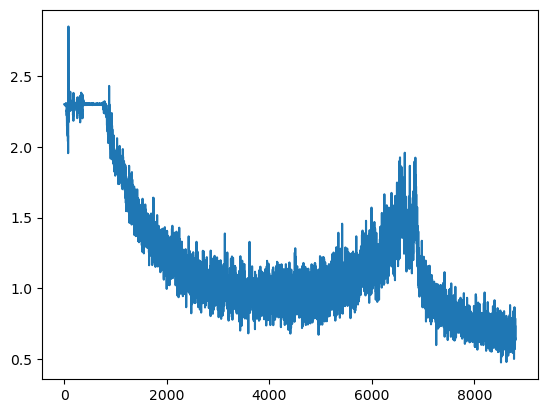

In [24]:
plt.plot(train_acc_list, label='train accuracy')
plt.plot(valid_acc_list, label='train accuracy')
plt.show()

plt.plot(minibatch_loss_list, label='loss')
plt.show()